<a href="https://colab.research.google.com/github/Ads369/Ads_2s/blob/main/ipynb/Lesson%2021/21_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Навигация по уроку**

1. [Рекуррентные нейронные сети](https://colab.research.google.com/drive/1Mm5yFeJXZT9YcwlQMGx_T5JcEVgV8ZWy)
2. [Одномерные сверточные нейронные сети](https://colab.research.google.com/drive/1SCmcJdfsaxpJiQz_SOMH6gixV-43zPIB)
3. [Сравнение архитектур рекуррентных и одномерных сверточных сетей](https://colab.research.google.com/drive/15-SEqMwU3ALZmiEtlJFZllc38VTGHkGu)
4. Домашняя работа

Когда вы еще учились в школе, то вас часто мучали написанием сочинений. Может быть даже кто-нибудь из вас увлекался написанием стихотворений, романов или прозы. А значит, в вас живет дух великого русского писателя. А вот интересно какого? В данной домашней работе мы это и выясним!

Чтобы узнать на какого писателя вы похожи необходимо выполнить следующее задание:

1. Скачать датасет с [писателями Русской литературы](https://storage.yandexcloud.net/academy.ai/russian_literature.zip). Каждый текст необходимо разбить на обучающую, проверочную и тестовую выборки, для этого модифицируйте функцию `seq_vectorize`, чтобы она возвращала все 3 выборки.
2. Используя материалы из ноутбука практического занятия [сравнение архитектур рекуррентных и одномерных сверточных сетей](https://colab.research.google.com/drive/15-SEqMwU3ALZmiEtlJFZllc38VTGHkGu), выберите лучший вариант нейронки и адаптируйте ее структуру.
3. Подгрузите веса Наташи как в уроке [20.3](https://colab.research.google.com/drive/1g_dX1XpRY--X6EjFflCC0717p9_9Y1SP) для слоя эмбендинга.
4. Заморозьте слой эмбединга.
5. Обучите модель на любом числе писателей (не менее 4-х) с балансировкой. Используйте обучающую выборку для обучения, а проверочную - в качестве валидационных данных (`validation_data`).
6. Постройте матрицу ошибок на тестовых образцах! В примерах мы строили на проверочных. Добейтесь средней точности более 70% на тестовых образцах. Получите 3 балла.
7. Если сможете добиться точности более 90% получите +1 балл.
8. Подготовьте свой текст и предложите нейронке предсказать на кого из русских писателей похож ваш текст. Вам необходимо построить круговую диаграмму с вероятностями предсказания моделью автора сочинения (по тестовой выборке). Если текст будет вашего авторства, то вы получите +1 балл. Если у вас плохо с фантазией, то возьмите небольшой фрагмент вашего любимого произведения любого автора, не представленного в датасете.

In [1]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
!pip install navec wget
%matplotlib inline

--2024-11-25 12:46:16--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar’

navec_hudlit_v1_12B 100%[===================>]  50.56M  14.5MB/s    in 4.6s    

2024-11-25 12:46:21 (11.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar’ saved [53012480/53012480]

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=461ddd4fca86e6f3eca3381d0e3e0069b90e89e88818dc37b06d846b413b1933
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import glob  # Вспомогательный модуль для работы с файловой системой
import os  # Модуль для работы с файловой системой

import matplotlib.pyplot as plt
import numpy as np
from keras.layers import (
    GRU,
    LSTM,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Embedding,
    Flatten,
    MaxPooling1D,
    SimpleRNN,
    SpatialDropout1D,
)
from keras.models import Sequential
from keras.utils import get_file, to_categorical
from navec import Navec
from sklearn.metrics import (  # Для работы с матрицей ошибок
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
data_path = get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip",
)

21547079/21547079 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
import zipfile

zip_ref = zipfile.ZipFile(data_path, "r")
for file in zip_ref.namelist():
    try:
        zip_ref.extract(file, "./dataset")
    except OSError as e:
        if "[Errno 36] File name too long:" in str(e):
            new_filename = file[:50] + "." + file.split(".")[-1]
            with zip_ref.open(file) as source:
                with open(f"./dataset/{new_filename}", "wb") as target:
                    target.write(source.read())
import wget

url = "https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar"
filename_navec = wget.download(url)
navec = Navec.load(filename_navec)

In [5]:
FILE_DIR_POEMS = "./dataset/poems"
file_list_poems = os.listdir(FILE_DIR_POEMS)
FILE_DIR_PROSE = "./dataset/prose"
file_list_prose = os.listdir(FILE_DIR_PROSE)
CLASS_LIST = list(set(file_list_poems + file_list_prose))
print("Общий список писателей:")
print(CLASS_LIST)

Общий список писателей:
['Gogol', 'Turgenev', 'Chekhov', 'Lermontov', 'Tolstoy', 'Nekrasov', 'Bryusov', 'Blok', 'Dostoevsky', 'Gorky', 'Herzen', 'Pushkin']


In [6]:
# Собираем в словарь весь датасет
all_texts = {}

for author in CLASS_LIST:
    all_texts[author] = ""
    for path in glob.glob("./dataset/prose/{}/*.txt".format(author)) + glob.glob(
        "./dataset/poems/{}/*.txt".format(author)
    ):
        with open(f"{path}", "r", errors="ignore") as f:
            text = f.read()
        all_texts[author] += " " + text.replace("\n", " ")

In [7]:
# Токенизация
embedding_dim = 300  # размерность векторов эмбединга (300d в имени эмбединга)
max_words = 15000  # Количество слов, рассматриваемых как признаки

# Используется встроенный в Keras токенизатор для разбиения текста и построения частотного словаря
tokenizer = Tokenizer(
    num_words=max_words,
    filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff',
    lower=True,
    split=" ",
    char_level=False,
)



In [8]:
# Построение частотного словаря по текстам
tokenizer.fit_on_texts(all_texts.values())

In [9]:
# Преобразуем текст в последовательности
seq_train = tokenizer.texts_to_sequences(all_texts.values())

In [10]:
# используем генератор цикла для получения длины текстов по каждому автору
total = sum(len(i) for i in seq_train)
print(f"Датасет состоит из {total} слов")

print("Общая выборка по писателям (по словам):")
mean_list = np.array([])
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    print(
        f"{author} - {len(seq_train[cls])} слов, доля в общей базе: {len(seq_train[cls])/total*100 :.2f}%"
    )
    mean_list = np.append(mean_list, len(seq_train[cls]))

print("Среднее значение слов: ", np.round(mean_list.mean()))
print("Медианное значение слов: ", np.median(mean_list))


median = int(np.median(mean_list))  # Зафиксировали медианное значение
CLASS_LIST_BALANCE = []  # Сбалансированный набор меток
seq_train_balance = []
for author in CLASS_LIST:
    cls = CLASS_LIST.index(author)
    if len(seq_train[cls]) > median * 0.6:
        seq_train_balance.append(seq_train[cls][:median])
        CLASS_LIST_BALANCE.append(author)

Датасет состоит из 5021084 слов
Общая выборка по писателям (по словам):
Gogol - 289177 слов, доля в общей базе: 5.76%
Turgenev - 305558 слов, доля в общей базе: 6.09%
Chekhov - 244761 слов, доля в общей базе: 4.87%
Lermontov - 46926 слов, доля в общей базе: 0.93%
Tolstoy - 1236769 слов, доля в общей базе: 24.63%
Nekrasov - 39272 слов, доля в общей базе: 0.78%
Bryusov - 349206 слов, доля в общей базе: 6.95%
Blok - 85431 слов, доля в общей базе: 1.70%
Dostoevsky - 1548394 слов, доля в общей базе: 30.84%
Gorky - 553966 слов, доля в общей базе: 11.03%
Herzen - 153296 слов, доля в общей базе: 3.05%
Pushkin - 168328 слов, доля в общей базе: 3.35%
Среднее значение слов:  418424.0
Медианное значение слов:  266969.0


In [11]:
total = sum(len(i) for i in seq_train_balance)

print("Сбалансированная выборка по писателям (по словам):")
mean_list_balance = np.array([])
for author in CLASS_LIST_BALANCE:
    cls = CLASS_LIST_BALANCE.index(author)
    print(
        f"{author} - {len(seq_train_balance[cls])} слов, "
        f"доля в общей базе: {len(seq_train_balance[cls])/total*100 :.2f}%"
    )
    mean_list_balance = np.append(mean_list_balance, len(seq_train_balance[cls]))

print("Среднее значение слов: ", np.round(mean_list_balance.mean()))
print("Медианное значение слов: ", np.median(mean_list_balance))

Сбалансированная выборка по писателям (по словам):
Gogol - 266969 слов, доля в общей базе: 13.25%
Turgenev - 266969 слов, доля в общей базе: 13.25%
Chekhov - 244761 слов, доля в общей базе: 12.15%
Tolstoy - 266969 слов, доля в общей базе: 13.25%
Bryusov - 266969 слов, доля в общей базе: 13.25%
Dostoevsky - 266969 слов, доля в общей базе: 13.25%
Gorky - 266969 слов, доля в общей базе: 13.25%
Pushkin - 168328 слов, доля в общей базе: 8.35%
Среднее значение слов:  251863.0
Медианное значение слов:  266969.0


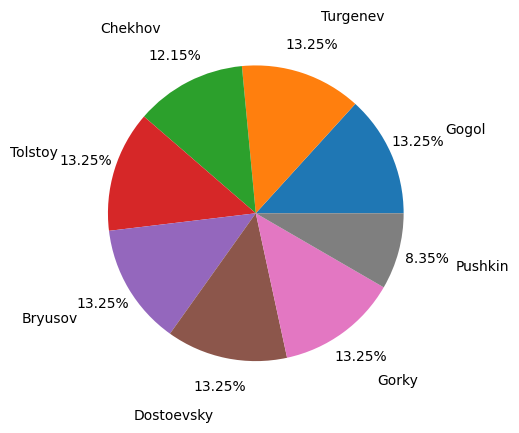

In [12]:
fig, ax = plt.subplots()
ax.pie(
    [
        len(i) for i in seq_train_balance
    ],  # формируем список значений как длина символов текста каждого автора
    labels=CLASS_LIST_BALANCE,  # список меток
    pctdistance=1.2,  # дистанция размещения % (1 - граница окружности)
    labeldistance=1.4,  # размещение меток (1 - граница окружности)
    autopct="%1.2f%%",  # формат для % (2 знака после запятой)
)
plt.show()

In [13]:
# Нарезка примеров из текста методом скользящего окна
WIN_SIZE = 1000  # Ширина окна в токенах
WIN_STEP = 100  # Шаг окна в токенах


# Функция разбиения последовательности на отрезки скользящим окном
# Последовательность разбивается на части до последнего полного окна
# Параметры:
# sequence - последовательность токенов
# win_size - размер окна
# step - шаг окна
def seq_split(sequence, win_size, step):
    # Делим строку на отрезки с помощью генератора цикла
    return [
        sequence[i : i + win_size] for i in range(0, len(sequence) - win_size + 1, step)
    ]


def seq_vectorize(
    seq_list,  # Последовательность
    test_split,  # Доля на тестовую выборку
    class_list,  # Список классов
    win_size,  # Ширина скользящего окна
    step,  # Шаг скользящего окна
):
    # Списки для результирующих данных
    x_train, y_train = [], []
    x_val, y_val = [], []
    x_test, y_test = [], []

    # Пробежимся по всем классам:
    for cls, class_item in enumerate(class_list):
        # Пороговое значение индекса для разбивки на тестовую и обучающую выборки
        gate_split = int(len(seq_list[cls]) * (1 - test_split))

        # Разбиваем последовательность токенов класса на отрезки
        vectors_train = seq_split(seq_list[cls][:gate_split], win_size, step)
        vectors_test_val = seq_split(seq_list[cls][gate_split:], win_size, step)

        # Разделение теста на val и test
        val_split = len(vectors_test_val) // 2
        vectors_val = vectors_test_val[:val_split]
        vectors_test = vectors_test_val[val_split:]

        # Добавляем отрезки в выборку
        x_train.extend(vectors_train)
        x_val.extend(vectors_val)
        x_test.extend(vectors_test)

        # Create one-hot encoded labels
        class_label = to_categorical(cls, len(class_list))

        # Для всех отрезков класса добавляем метки класса в виде one-hot-encoding
        # Каждую метку берем len(vectors) раз, так она одинакова для всех выборок одного класса
        y_train.extend([class_label] * len(vectors_train))
        y_val.extend([class_label] * len(vectors_val))
        y_test.extend([class_label] * len(vectors_test))

    # Возвращаем результатов как numpy-массивов
    return (
        np.array(x_train),
        np.array(y_train),
        np.array(x_val),
        np.array(y_val),
        np.array(x_test),
        np.array(y_test),
    )

In [14]:
x_train, y_train, x_val, y_val, x_test, y_test = seq_vectorize(
    seq_train_balance, 0.1, CLASS_LIST_BALANCE, WIN_SIZE, WIN_STEP
)
print(f"Форма входных данных для обучающей выборки: {x_train.shape}")
print(f"Форма выходных данных (меток) для обучающей выборки: {y_train.shape}")
print(f"Форма входных данных для валидационной выборки: {x_val.shape}")
print(f"Форма выходных данных (меток) для валидационной выборки: {y_val.shape}")
print(f"Форма входных данных для тестовой выборки: {x_test.shape}")
print(f"Форма выходных данных (меток) для тестовой выборки: {y_test.shape}")

Форма входных данных для обучающей выборки: (18056, 1000)
Форма выходных данных (меток) для обучающей выборки: (18056, 8)
Форма входных данных для валидационной выборки: (964, 1000)
Форма выходных данных (меток) для валидационной выборки: (964, 8)
Форма входных данных для тестовой выборки: (972, 1000)
Форма выходных данных (меток) для тестовой выборки: (972, 8)


In [15]:
# Шаг 8. Определим вспомагательные функции
# Вывод графиков точности и ошибки
def show_plot(history, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle("График процесса обучения модели: " + title)
    ax1.plot(history.history["accuracy"], label="График точности на обучающей выборке")
    ax1.plot(
        history.history["val_accuracy"], label="График точности на проверочной выборке"
    )
    ax1.xaxis.get_major_locator().set_params(
        integer=True
    )  # На оси х показываем целые числа
    ax1.set_xlabel("Эпоха обучения")
    ax1.set_ylabel("График точности")
    ax1.legend()

    ax2.plot(history.history["loss"], label="Ошибка на обучающей выборке")
    ax2.plot(history.history["val_loss"], label="Ошибка на проверочной выборке")
    ax2.xaxis.get_major_locator().set_params(
        integer=True
    )  # На оси х показываем целые числа
    ax2.set_xlabel("Эпоха обучения")
    ax2.set_ylabel("Ошибка")
    ax2.legend()
    plt.show()


# Функция вывода предсказанных значений
def show_confusion_matrix(y_true, y_pred, class_labels):
    # Матрица ошибок
    cm = confusion_matrix(
        np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), normalize="true"
    )
    # Округление значений матрицы ошибок
    cm = np.around(cm, 3)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(f"Матрица ошибок", fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    plt.gca().images[-1].colorbar.remove()  # Убираем ненужную цветовую шкалу
    plt.xlabel("Предсказанные классы", fontsize=16)
    plt.ylabel("Верные классы", fontsize=16)
    fig.autofmt_xdate(rotation=45)  # Наклон меток горизонтальной оси
    plt.show()

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print(
        "\nСредняя точность распознавания: {:3.0f}%".format(
            100.0 * cm.diagonal().mean()
        )
    )

In [16]:
def loadEmbedding():
    word_index = tokenizer.word_index
    embeddings_index = navec

    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
# # Рубрика Эксперименты!!!

#### **Embedding(Natasha) + SimpleRNN(10) + Dropout(0.3)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_1 = Sequential()

model_SimpleRNN_1.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_1.add(SpatialDropout1D(0.3))
# Слой нормализации данных
model_SimpleRNN_1.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_1.add(SimpleRNN(10))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_1.add(Dropout(0.3))
# Выходной слой классификатора
model_SimpleRNN_1.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_SimpleRNN_1.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history = model_SimpleRNN_1.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 34s 159ms/step - accuracy: 0.1337 - loss: 2.3625 - val_accuracy: 0.1722 - val_loss: 2.0859
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 28s 116ms/step - accuracy: 0.1704 - loss: 2.1184 - val_accuracy: 0.1909 - val_loss: 2.0535
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.1952 - loss: 2.0414 - val_accuracy: 0.1981 - val_loss: 2.0387
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.2312 - loss: 1.9835 - val_accuracy: 0.2127 - val_loss: 2.0259
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 118ms/step - accuracy: 0.2574 - loss: 1.9452 - val_accuracy: 0.2272 - val_loss: 2.0173
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.2862 - loss: 1.8836 - val_accuracy: 0.2479 - val_loss: 2.0005
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - accuracy: 0.3194 - loss: 1.8272 - val_accuracy: 0.2562 - val_loss: 1.9945
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.3453 - loss: 1

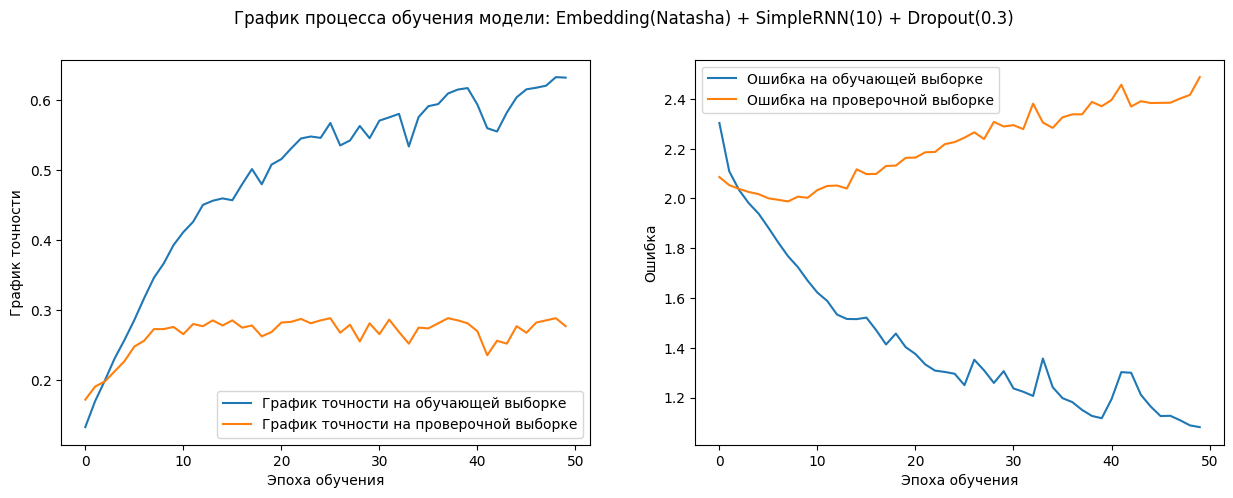

In [ ]:
show_plot(history, "Embedding(Natasha) + SimpleRNN(10) + Dropout(0.3)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step


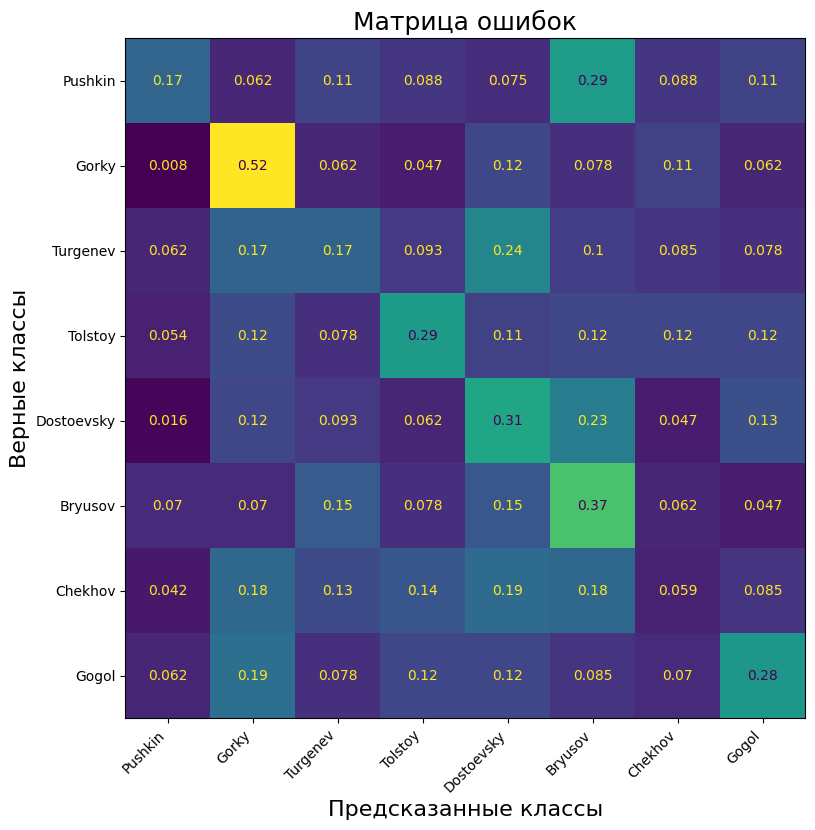


Средняя точность распознавания:  27%


In [ ]:
y_pred = model_SimpleRNN_1.predict(x_test)
show_confusion_matrix(y_test, y_pred, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + SimpleRNN(5) + Dropout(0.2)**

In [ ]:
# Создание последовательной модели нейросети
model_SimpleRNN_2 = Sequential()

model_SimpleRNN_2.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)

# Слой регуляризации, "выключает" 1D карты объектов из эмбеддинг-векторов
model_SimpleRNN_2.add(SpatialDropout1D(0.2))
# Слой нормализации данных
model_SimpleRNN_2.add(BatchNormalization())
# Рекуррентный слой
model_SimpleRNN_2.add(SimpleRNN(5))
# Слой регуляризации Dropout для отдельных нейронов
model_SimpleRNN_2.add(Dropout(0.2))
# Выходной слой классификатора
model_SimpleRNN_2.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_SimpleRNN_2.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history2 = model_SimpleRNN_2.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 26s 151ms/step - accuracy: 0.1219 - loss: 2.2512 - val_accuracy: 0.1369 - val_loss: 2.1044
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 34s 119ms/step - accuracy: 0.1692 - loss: 2.0753 - val_accuracy: 0.1276 - val_loss: 2.0974
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.2020 - loss: 2.0216 - val_accuracy: 0.1317 - val_loss: 2.0976
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 119ms/step - accuracy: 0.2316 - loss: 1.9725 - val_accuracy: 0.1390 - val_loss: 2.0953
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.2562 - loss: 1.9336 - val_accuracy: 0.1442 - val_loss: 2.0959
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 117ms/step - accuracy: 0.2819 - loss: 1.8936 - val_accuracy: 0.1494 - val_loss: 2.1054
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 16s 116ms/step - accuracy: 0.3020 - loss: 1.8531 - val_accuracy: 0.1504 - val_loss: 2.1223
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 117ms/step - accuracy: 0.3267 - loss: 1

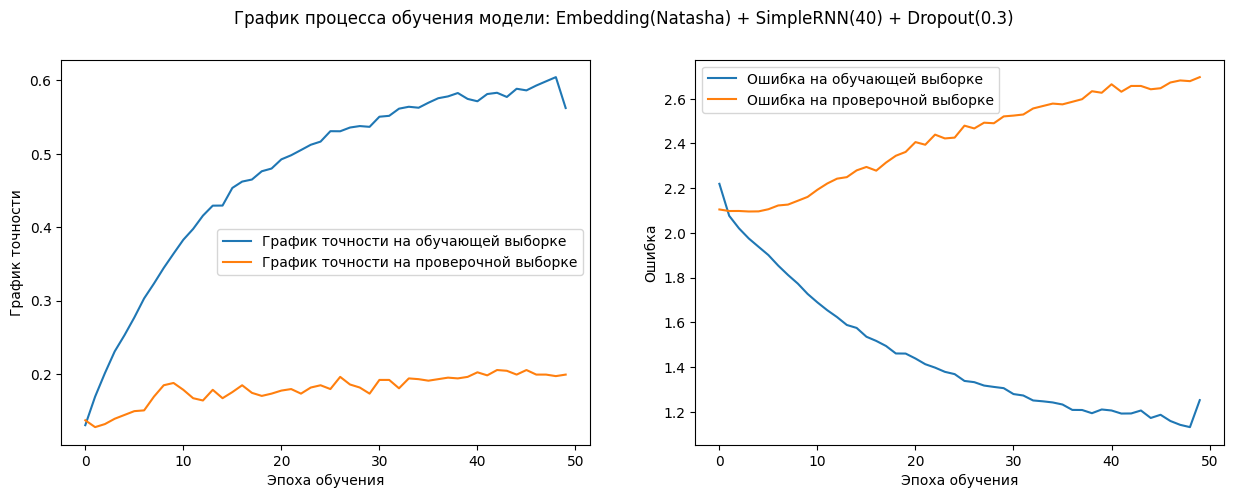

In [ ]:
show_plot(history2, "Embedding(Natasha) + SimpleRNN(40) + Dropout(0.3)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


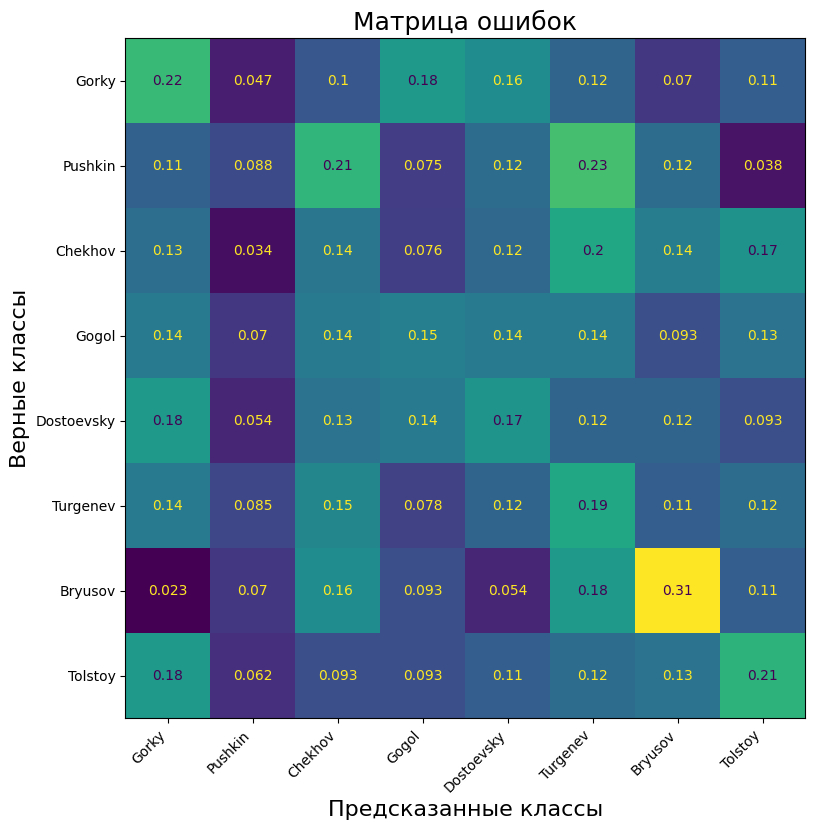


Средняя точность распознавания:  18%


In [ ]:
y_pred2 = model_SimpleRNN_2.predict(x_test)
show_confusion_matrix(y_test, y_pred2, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + GRU(10) + Dropout(0.2)**

Слой GRU в Keras с параметрами регуляризации не считается на cuda ядрах GPU процессора. При запуске на GPU увидите предупреждение. Поэтому расчеты будут производиться долго и придется запастись терпением.

In [ ]:
model_GRU_3 = Sequential()
model_GRU_3.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_GRU_3.add(SpatialDropout1D(0.2))
model_GRU_3.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_3.add(GRU(10, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
model_GRU_3.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_GRU_3.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history3 = model_GRU_3.fit(
    x_train, y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 33s 193ms/step - accuracy: 0.1336 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 33s 158ms/step - accuracy: 0.1318 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.1292 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.1322 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.1345 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.1355 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.1361 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 159ms/step - accuracy: 0.1330 - loss: nan - val_accuracy: 0.1328 - val_loss: nan


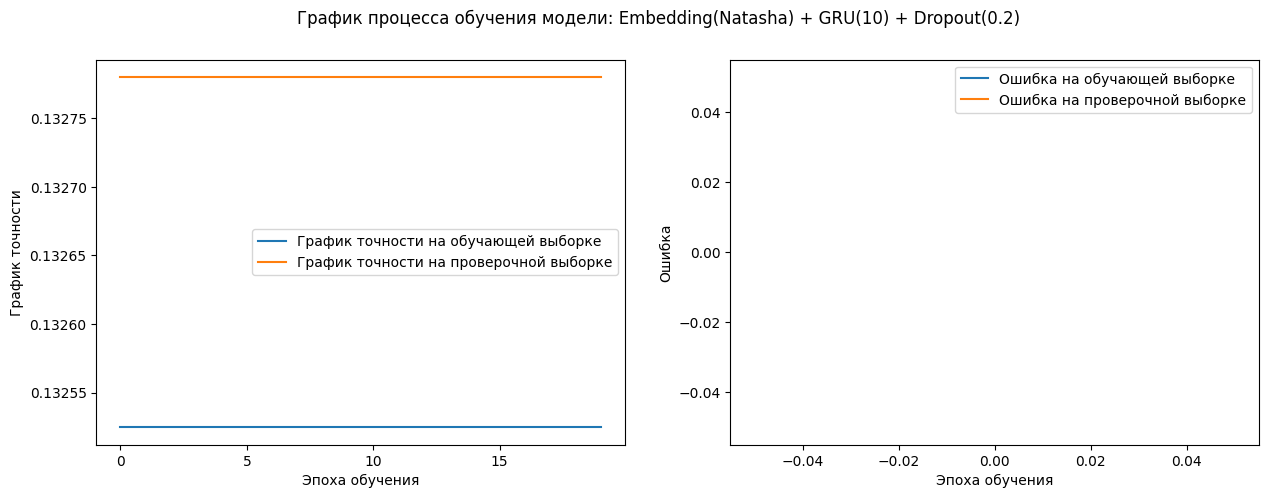

In [ ]:
show_plot(history3, "Embedding(Natasha) + GRU(10) + Dropout(0.2)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


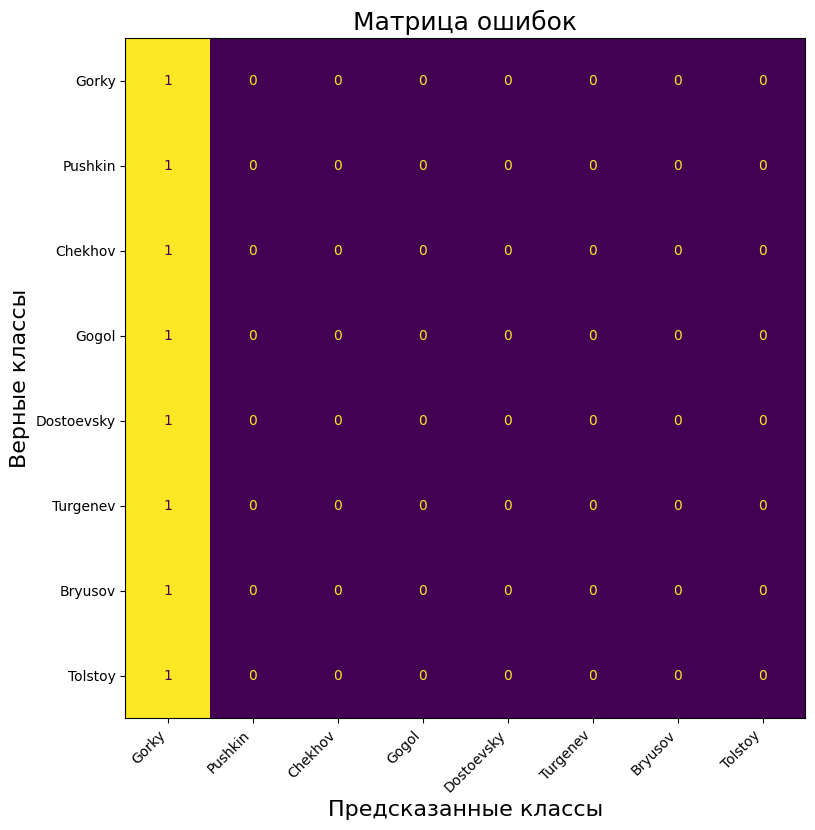


Средняя точность распознавания:  12%


In [ ]:
y_pred3 = model_GRU_3.predict(x_test)
show_confusion_matrix(y_test, y_pred3, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + GRU(40) + Dropout(0.2)**

In [ ]:
model_GRU_4 = Sequential()
model_GRU_4.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_GRU_4.add(SpatialDropout1D(0.2))
model_GRU_4.add(BatchNormalization())
# Рекуррентный слой GRU
model_GRU_4.add(GRU(40, dropout=0.2, recurrent_dropout=0.2, activation="relu"))
model_GRU_4.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_GRU_4.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history4 = model_GRU_4.fit(
    x_train, y_train, epochs=20, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 44s 263ms/step - accuracy: 0.1341 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 2/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 69s 198ms/step - accuracy: 0.1358 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 3/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.1300 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 4/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.1340 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 5/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.1353 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 6/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.1331 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 7/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 200ms/step - accuracy: 0.1329 - loss: nan - val_accuracy: 0.1328 - val_loss: nan
Epoch 8/20
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 198ms/step - accuracy: 0.1338 - loss: nan - val_accuracy: 0.1328 - val_loss: nan


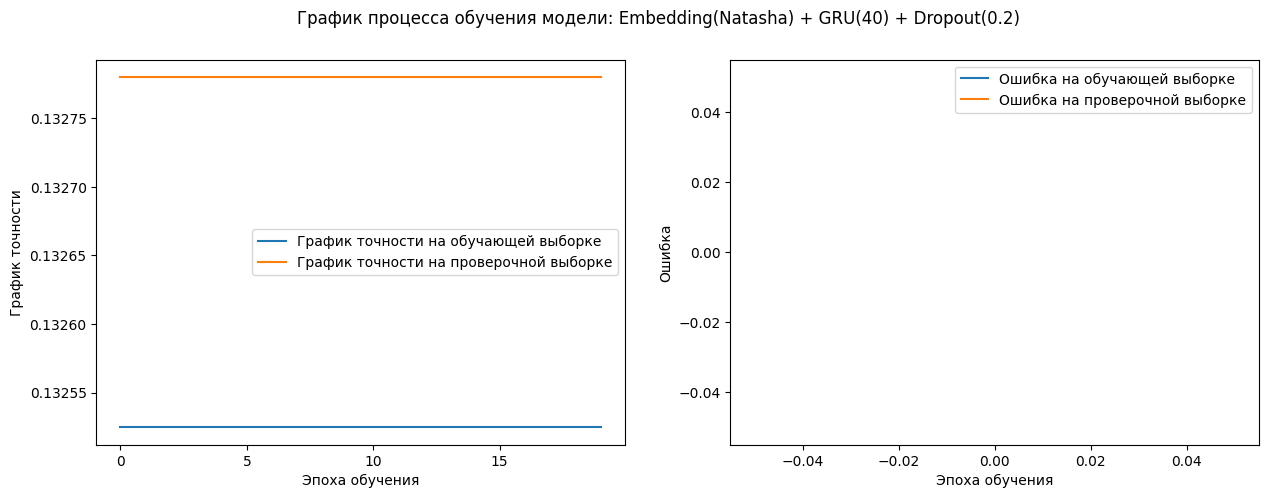

In [ ]:
show_plot(history4, "Embedding(Natasha) + GRU(40) + Dropout(0.2)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


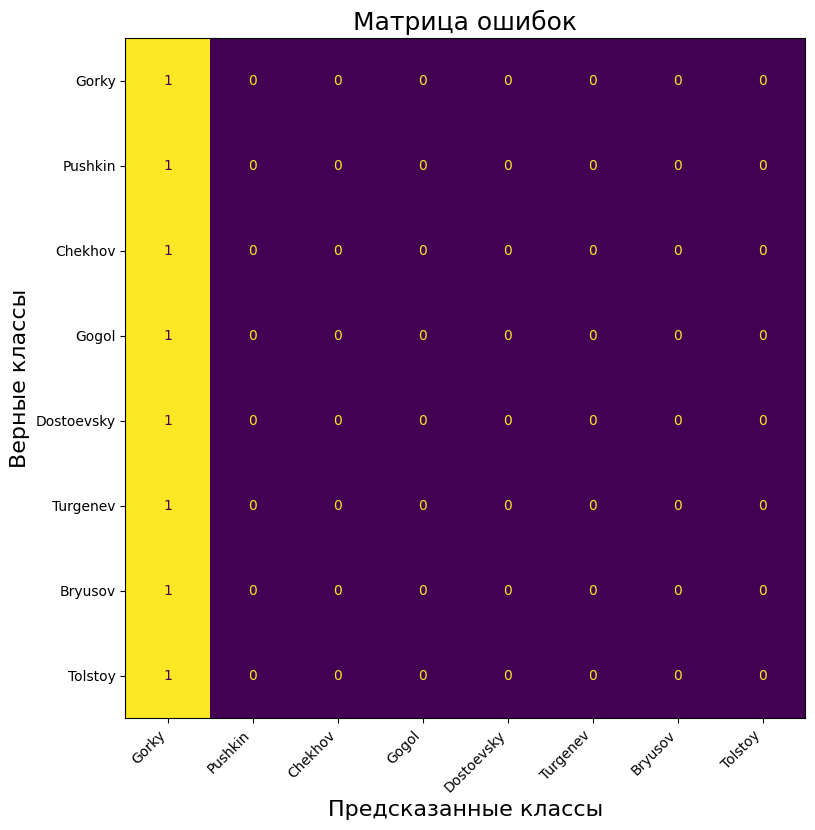


Средняя точность распознавания:  12%


In [ ]:
y_pred4 = model_GRU_4.predict(x_test)
show_confusion_matrix(y_test, y_pred4, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + LSTM(20) + Dropout(0.2)**

In [ ]:
model_LSTM_5 = Sequential()
model_LSTM_5.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_LSTM_5.add(SpatialDropout1D(0.2))
model_LSTM_5.add(BatchNormalization())

# Рекуррентный слой LSTM
model_LSTM_5.add(LSTM(20))
model_LSTM_5.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model_LSTM_5.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history5 = model_LSTM_5.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 76ms/step - accuracy: 0.1698 - loss: 2.0618 - val_accuracy: 0.2915 - val_loss: 1.8992
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.3493 - loss: 1.7977 - val_accuracy: 0.4896 - val_loss: 1.4712
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.6184 - loss: 1.1279 - val_accuracy: 0.6878 - val_loss: 1.0022
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.8387 - loss: 0.5865 - val_accuracy: 0.9149 - val_loss: 0.3671
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.8939 - loss: 0.3807 - val_accuracy: 0.8900 - val_loss: 0.4074
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 75ms/step - accuracy: 0.9557 - loss: 0.1977 - val_accuracy: 0.9232 - val_loss: 0.2718
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9847 - loss: 0.0899 - val_accuracy: 0.8683 - val_loss: 0.4239
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9901 - loss: 0.0592 - 

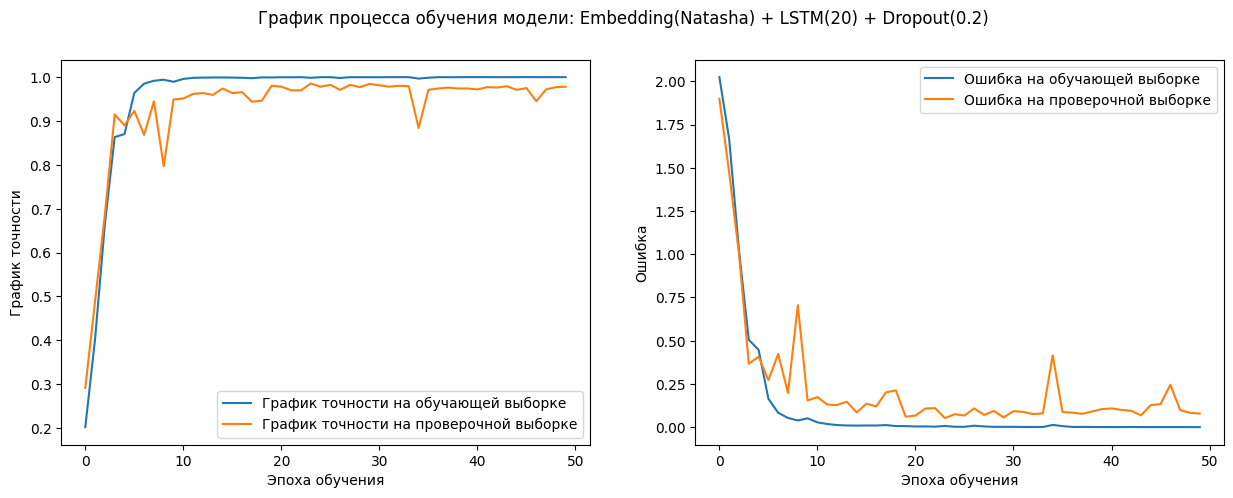

In [19]:
show_plot(history5, "Embedding(Natasha) + LSTM(20) + Dropout(0.2)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


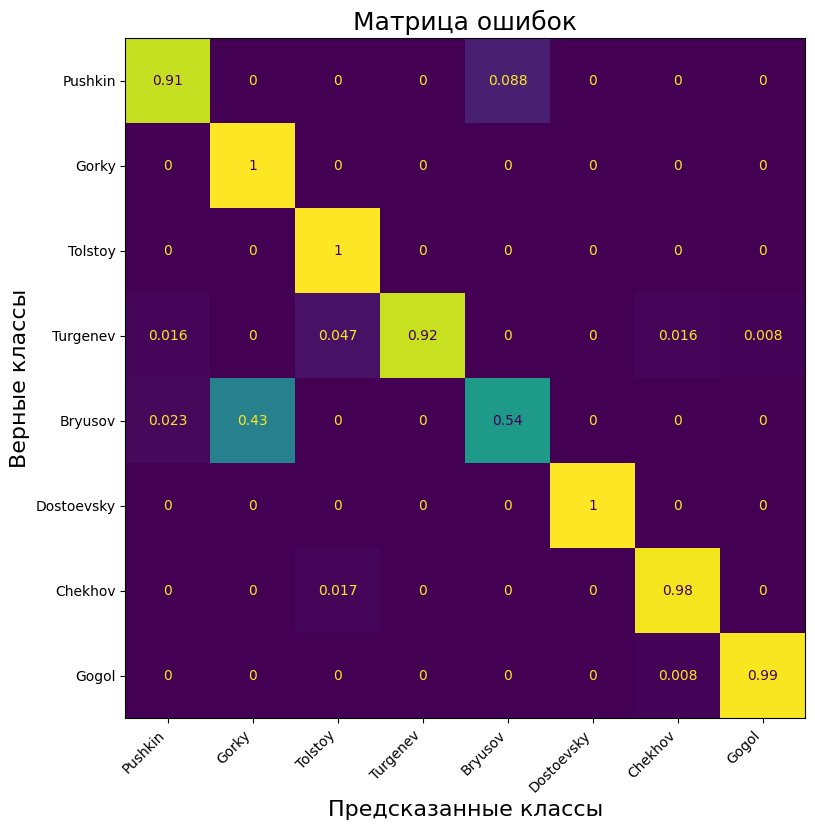


Средняя точность распознавания:  92%


In [20]:
y_pred5 = model_LSTM_5.predict(x_test)
show_confusion_matrix(y_test, y_pred5, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + LSTM(100) + Dropout(0.3)**

In [17]:
model_LSTM_6 = Sequential()
model_LSTM_6.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_LSTM_6.add(SpatialDropout1D(0.3))
model_LSTM_6.add(BatchNormalization())

# Рекуррентный слой LSTM
model_LSTM_6.add(LSTM(100))
model_LSTM_6.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
model_LSTM_6.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history6 = model_LSTM_6.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.2039 - loss: 2.0132 - val_accuracy: 0.3257 - val_loss: 2.1090
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - accuracy: 0.4898 - loss: 1.4568 - val_accuracy: 0.4606 - val_loss: 1.6626
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 112ms/step - accuracy: 0.6058 - loss: 1.1905 - val_accuracy: 0.5695 - val_loss: 1.5238
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 113ms/step - accuracy: 0.7526 - loss: 0.8087 - val_accuracy: 0.8278 - val_loss: 0.5075
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - accuracy: 0.9179 - loss: 0.3047 - val_accuracy: 0.8755 - val_loss: 0.4251
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 115ms/step - accuracy: 0.9685 - loss: 0.1345 - val_accuracy: 0.9647 - val_loss: 0.1308
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 116ms/step - accuracy: 0.9890 - loss: 0.0481 - val_accuracy: 0.9523 - val_loss: 0.1690
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step - accuracy: 0.9929 - loss: 0

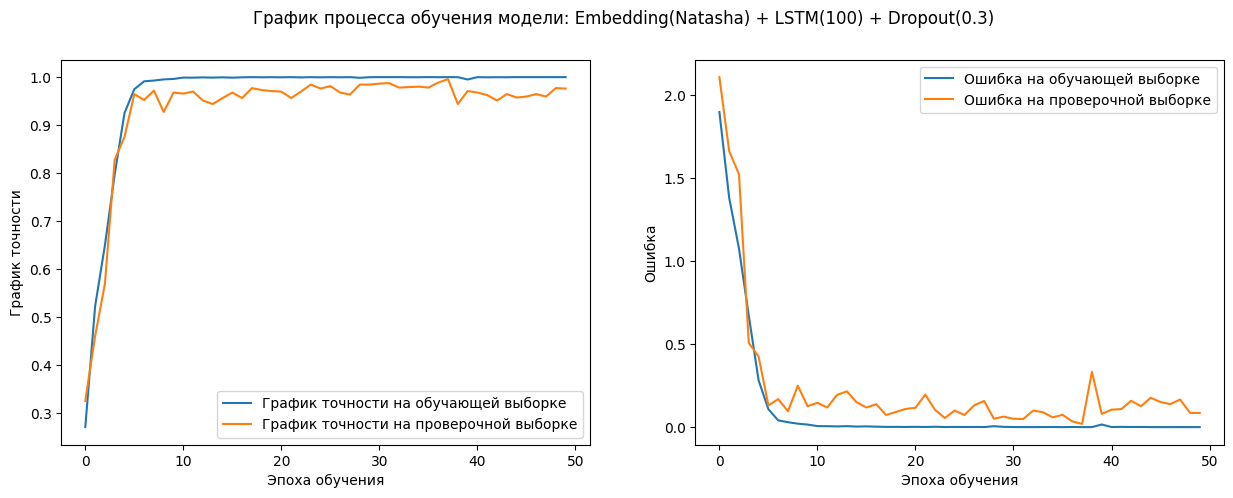

In [19]:
show_plot(history6, "Embedding(Natasha) + LSTM(100) + Dropout(0.3)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


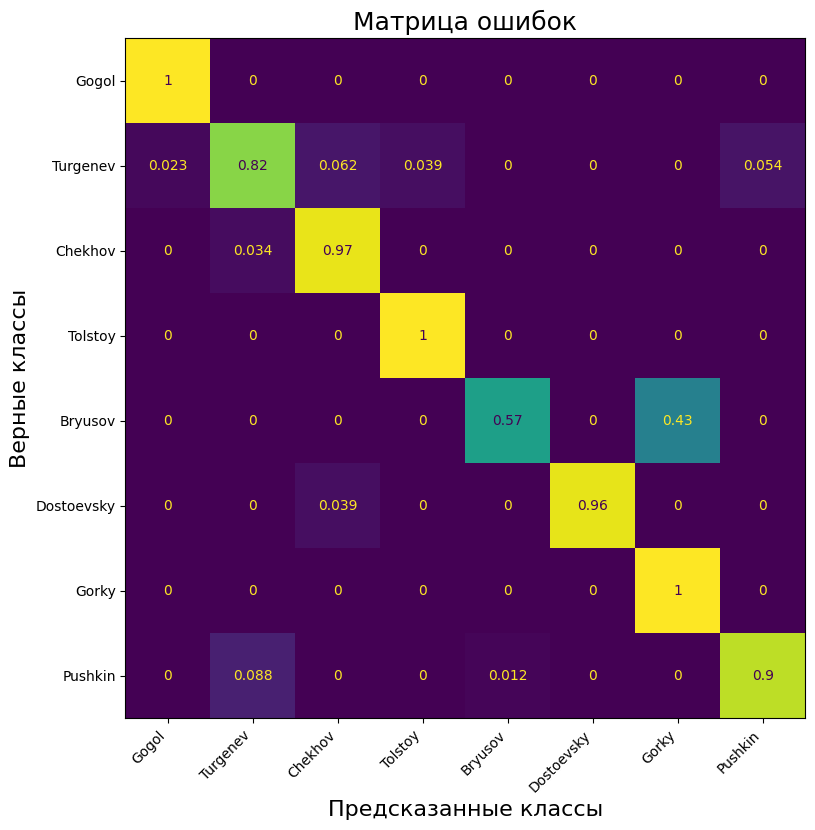


Средняя точность распознавания:  90%


In [20]:
y_pred6 = model_LSTM_6.predict(x_test)
show_confusion_matrix(y_test, y_pred6, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)**

`Bidirectional(LSTM(8, return_sequences=True))` – этот слой
активизирует двунаправленную сеть **LSTM**;

`GRU(16, return_sequences=True, reset_after=True)` – параметр `reset_after=True` означает сброс данных.

In [ ]:
model_MIX = Sequential()
model_MIX.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_MIX.add(SpatialDropout1D(0.3))
model_MIX.add(BatchNormalization())

# Два двунаправленных рекуррентных слоя LSTM
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Bidirectional(LSTM(8, return_sequences=True)))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Два рекуррентных слоя GRU
model_MIX.add(GRU(16, return_sequences=True, reset_after=True))
model_MIX.add(GRU(16, reset_after=True))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())

# Дополнительный полносвязный слой
model_MIX.add(Dense(100, activation="relu"))
model_MIX.add(Dropout(0.3))
model_MIX.add(BatchNormalization())
model_MIX.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_MIX.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history_mix = model_MIX.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 39s 229ms/step - accuracy: 0.1382 - loss: 2.4698 - val_accuracy: 0.1504 - val_loss: 2.0502
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 40s 220ms/step - accuracy: 0.1742 - loss: 2.1490 - val_accuracy: 0.2956 - val_loss: 1.9274
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.2388 - loss: 1.9622 - val_accuracy: 0.3745 - val_loss: 1.7724
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 223ms/step - accuracy: 0.3545 - loss: 1.7020 - val_accuracy: 0.4243 - val_loss: 1.6252
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 221ms/step - accuracy: 0.4375 - loss: 1.4552 - val_accuracy: 0.4678 - val_loss: 1.5584
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 220ms/step - accuracy: 0.5165 - loss: 1.2491 - val_accuracy: 0.3745 - val_loss: 1.7319
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 42s 225ms/step - accuracy: 0.6509 - loss: 0.9525 - val_accuracy: 0.5571 - val_loss: 1.5826
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 41s 222ms/step - accuracy: 0.7875 - loss: 0

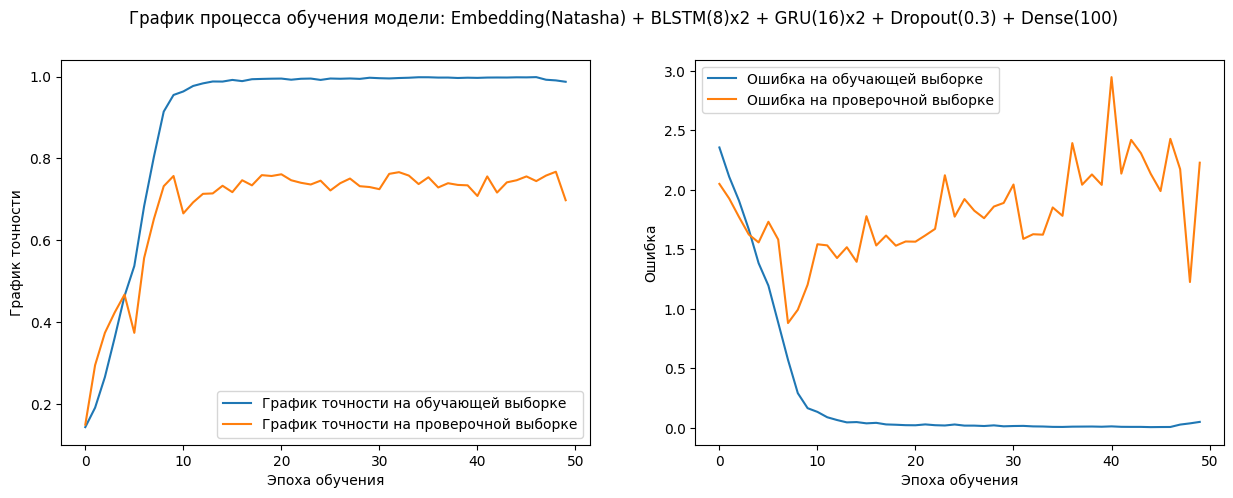

In [ ]:
show_plot(
    history_mix,
    "Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100)",
)

31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


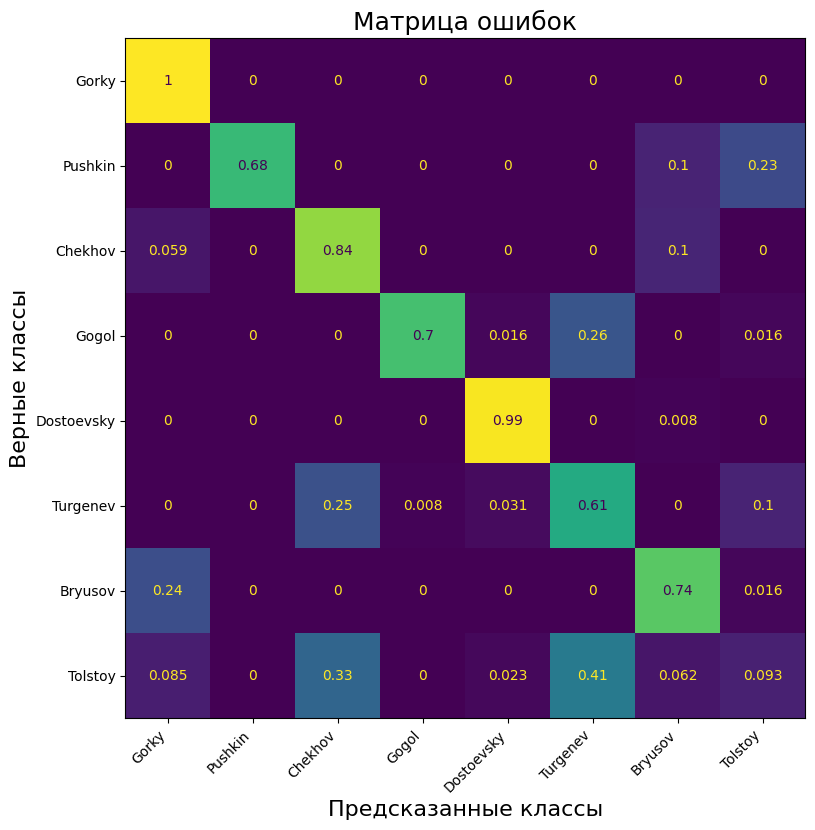


Средняя точность распознавания:  71%


In [ ]:
y_pred_mix = model_MIX.predict(x_test)
show_confusion_matrix(y_test, y_pred_mix, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + Conv1D(20)x2 + Dropout(0.2)**

In [ ]:
model_Conv1D = Sequential()
model_Conv1D.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_Conv1D.add(SpatialDropout1D(0.2))
model_Conv1D.add(BatchNormalization())
# Два слоя одномерной свертки Conv1D
model_Conv1D.add(Conv1D(20, 5, activation="relu", padding="same"))
model_Conv1D.add(Conv1D(20, 5, activation="relu"))
# Слой подвыборки/пулинга с функцией максимума
model_Conv1D.add(MaxPooling1D(2))
model_Conv1D.add(Dropout(0.2))
# Слой пакетной нормализации
model_Conv1D.add(BatchNormalization())
# Слой выравнивания в вектор
model_Conv1D.add(Flatten())
model_Conv1D.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_Conv1D.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history_1D = model_Conv1D.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 25s 120ms/step - accuracy: 0.3486 - loss: 2.0392 - val_accuracy: 0.1328 - val_loss: 8.1081
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - accuracy: 0.9022 - loss: 0.2861 - val_accuracy: 0.1826 - val_loss: 6.3548
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9830 - loss: 0.0565 - val_accuracy: 0.5145 - val_loss: 2.7382
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9952 - loss: 0.0199 - val_accuracy: 0.6898 - val_loss: 1.5313
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9946 - loss: 0.0195 - val_accuracy: 0.7355 - val_loss: 1.1616
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9979 - loss: 0.0087 - val_accuracy: 0.7635 - val_loss: 1.1274
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.7541 - val_loss: 1.3409
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 83ms/step - accuracy: 0.9957 - loss: 0.0129 -

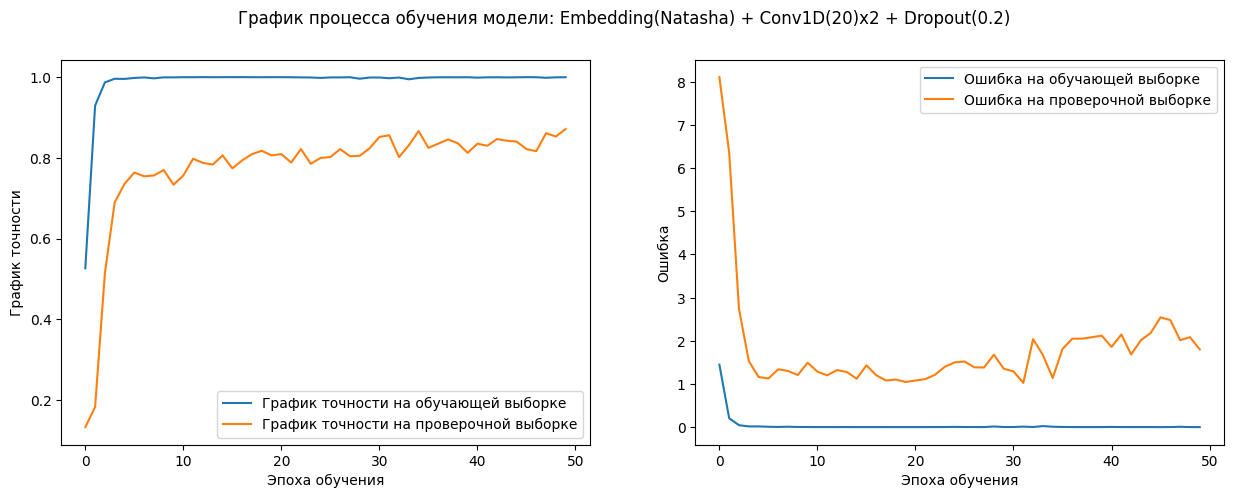

In [ ]:
show_plot(history_1D, "Embedding(Natasha) + Conv1D(20)x2 + Dropout(0.2)")

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


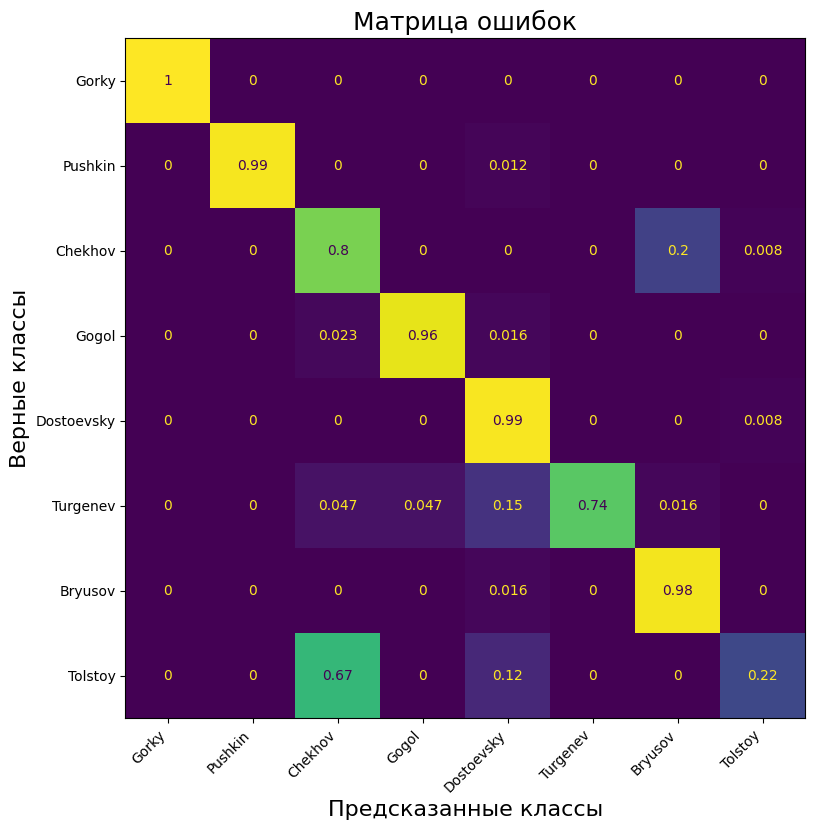


Средняя точность распознавания:  84%


In [ ]:
y_pred_1d = model_Conv1D.predict(x_test)
show_confusion_matrix(y_test, y_pred_1d, CLASS_LIST_BALANCE)

#### **Embedding(Natasha) + Conv1D(20)x3 + LSTM(4)x2 + Dropout(0.2) + Dense(100)**

In [ ]:
model_Conv_LSTM = Sequential()
model_Conv_LSTM.add(
    Embedding(max_words, embedding_dim, input_length=WIN_SIZE, weights=loadEmbedding())
)
model_Conv_LSTM.add(SpatialDropout1D(0.2))
# Рекуррентный слой LSTM
model_Conv_LSTM.add(LSTM(4, return_sequences=1))
# Полносвязный слой
model_Conv_LSTM.add(Dense(100, activation="relu"))
# Сверточный слой
model_Conv_LSTM.add(Conv1D(20, 5, activation="relu"))
# Рекуррентный слой LSTM
model_Conv_LSTM.add(LSTM(4, return_sequences=1))
# Слой регуляризации Dropout
model_Conv_LSTM.add(Dropout(0.2))
# Слой пакетной нормализации
model_Conv_LSTM.add(BatchNormalization())
# Два сверточных слоя
model_Conv_LSTM.add(Conv1D(20, 5, activation="relu"))
model_Conv_LSTM.add(Conv1D(20, 5, activation="relu"))
# Слой подвыборки/пулинга с функцией максимума
model_Conv_LSTM.add(MaxPooling1D(2))
model_Conv_LSTM.add(Dropout(0.2))
model_Conv_LSTM.add(BatchNormalization())
# Слой выравнивания в вектор
model_Conv_LSTM.add(Flatten())
model_Conv_LSTM.add(Dense(len(CLASS_LIST_BALANCE), activation="softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model_Conv_LSTM.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
history_1D_LSTM = model_Conv_LSTM.fit(
    x_train, y_train, epochs=50, batch_size=128, validation_data=(x_val, y_val)
)

Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.1871 - loss: 2.5238 - val_accuracy: 0.1328 - val_loss: 4.1322
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.7268 - loss: 0.7510 - val_accuracy: 0.1328 - val_loss: 7.4379
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9704 - loss: 0.0929 - val_accuracy: 0.1929 - val_loss: 7.1110
Epoch 4/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.9941 - loss: 0.0220 - val_accuracy: 0.4461 - val_loss: 3.0667
Epoch 5/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9977 - loss: 0.0098 - val_accuracy: 0.4108 - val_loss: 4.0057
Epoch 6/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9937 - loss: 0.0198 - val_accuracy: 0.7718 - val_loss: 1.5495
Epoch 7/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 20s 85ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.7282 - val_loss: 1.3871
Epoch 8/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9996 - loss: 0.0026 - 

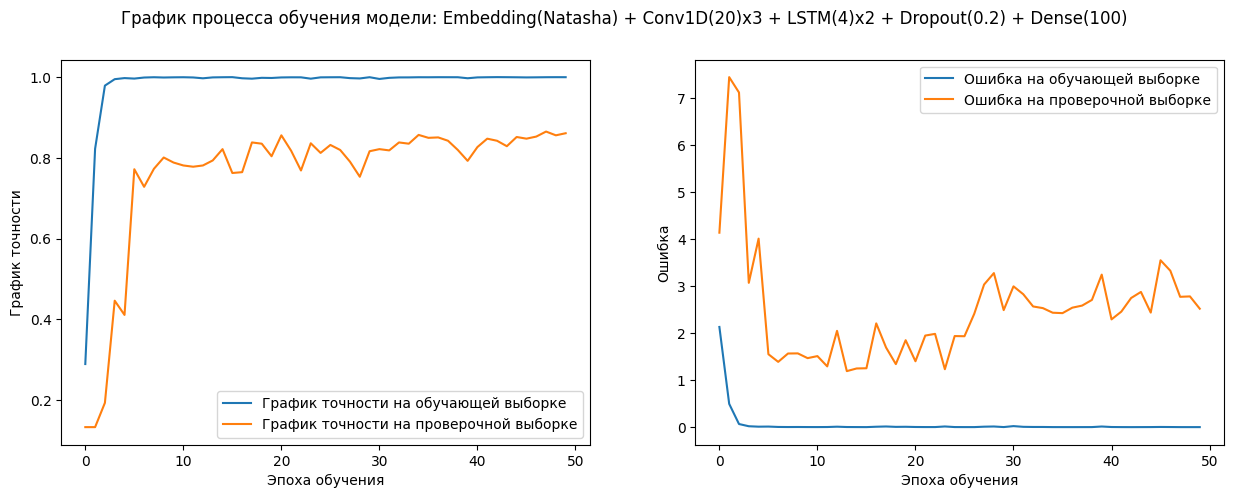

In [ ]:
show_plot(
    history_1D_LSTM,
    "Embedding(Natasha) + Conv1D(20)x3 + LSTM(4)x2 + Dropout(0.2) + Dense(100)",
)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


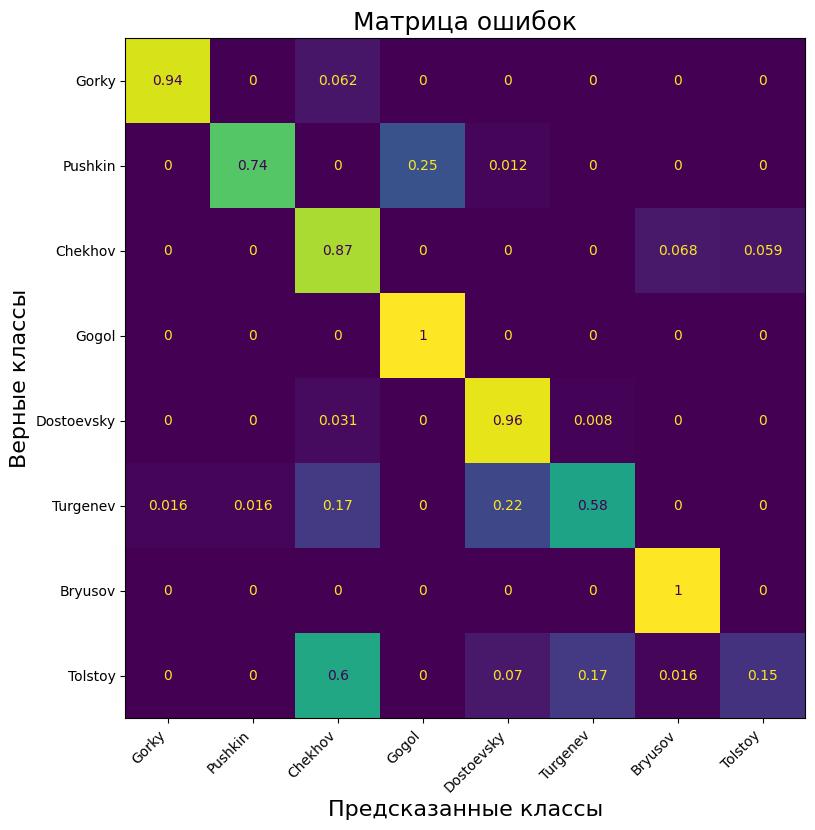


Средняя точность распознавания:  78%


In [ ]:
y_pred_lstm = model_Conv_LSTM.predict(x_test)
show_confusion_matrix(y_test, y_pred_lstm, CLASS_LIST_BALANCE)

- Embedding(Natasha) + SimpleRNN(10) + Dropout(0.3) = **27**%
- Embedding(Natasha) + SimpleRNN(5) + Dropout(0.2) = **18**%
- Embedding(Natasha) + GRU(10) + Dropout(0.2) = **12**%
- Embedding(Natasha) + GRU(40) + Dropout(0.2) = **12**%
- Embedding(Natasha) + LSTM(20) + Dropout(0.2) = **95**%
- Embedding(Natasha) + LSTM(100) + Dropout(0.3) = **91**%
- Embedding(Natasha) + BLSTM(8)x2 + GRU(16)x2 + Dropout(0.3) + Dense(100) = **71**%
- Embedding(Natasha) + Conv1D(20)x2 + Dropout(0.2) = **78**%


In [25]:
# Мой текст

my_text = """
Когда-то работая с психологом, мы пришли к выводу. Что я очень тактильный человек, и мне нужно много тактила, критически много.
И вот парень 28 лет, одинок, где же мне взять тактил? Знаю - единоборства.

Я пошел на MMA. Проходил около месяца. И вот каждая тренировка становилась для меня все более сложной и невыносимой. Я стараюсь жить в гармони с собой и своим телом. И каждый раз мое тело сообщало, что оно не готово, что ему еще нужно время на восстановление.

Тогда же, я познакомился с девочкой в интернете. И вот, я делюсь с ней, своей давней мечтой - станцевать вальс на набережной, это так красиво и романтично. И она отвечает мне: "Ну я конечно не вальс, но танцую. И мы иногда танцуем на набережной.... И кстати, у нас сегодня открытый урок".

И тут я понял это знак. Надо пробовать. И вот я пришел, выучил шаг и 2 фигуры. И нам говорят: "А сегодня мы танцуем на набережной, кто хочет может пойти с нами". Вот она мечта, на расстоянии вытянутой руки.

И я пошёл. Я знал всего 2 фигуры и танцевал их покругу, но в тот момент, я считал себя самым лучшим танцором на свете, самым офигенным мужиком. Не помню было ли такое ощущение до или после. Короче, там я танцевал с каждой, я отхастлил всех партнерш.

В конце нам говорят: "А завтра у нас ещё будет вечеринка."
И с тех пор я в Хастле.
"""

control_model = model_LSTM_6


In [27]:
def predict_text(model, text, tokenizer, max_length, class_labels):
    sequences = tokenizer.texts_to_sequences([text])

    padded_sequence = pad_sequences(
        sequences,
        maxlen=max_length,
        padding='post',
        truncating='post'
    )

    prediction = model.predict(padded_sequence, verbose=0)
    predicted_class = np.argmax(prediction)

    return class_labels[predicted_class]

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

try:
    predicted_class = predict_text(
        model=control_model,
        text=my_text,
        tokenizer=tokenizer,
        max_length=max_words,
        class_labels=CLASS_LIST_BALANCE
    )
    print(f"Predicted class: {predicted_class}")

except Exception as e:
    print(f"Error occurred: {str(e)}")

Predicted class: Pushkin
